# 07.2a: General-Purpose Sky Map

**Goal:** Visualize any vector set from any viewpoint using any coordinate basis.

This notebook is designed for maximum flexibility and reusability:
- Load vectors from any safetensors file
- Define coordinate system with custom basis vectors
- View from any point (or from origin)
- Color by uniform, scalar field, or grouped subsets
- Mask specific tokens
- Zoom to any region of sky
- Generate both Mollweide and rectangular projections

**Coordinate convention (right-hand rule):**
- +Z = North (north pole, +90° latitude)
- +X = Meridian (prime meridian, 0° longitude)
- +Y = Equinox (+90° longitude, perpendicular to X)

**Key feature:** Tie-aware CDF flattening preserves degeneracy while correcting for high-dimensional clustering.

## Parameters

In [44]:
# ============================================================================
# REQUIRED DATA
# ============================================================================

TENSOR_DIR = "../data/tensors"

# Input vectors
VECTORS_FILE = "gamma_centered_qwen3_4b_instruct_2507.safetensors"
VECTORS_KEY = "gamma_centered"

# Basis vectors (defines coordinate system)
BASIS_FILE = "pca_basis_vectors.safetensors"  # Will create in 07.3a
BASIS_KEYS = {
    'north': '1',      # +Z: north pole (+90° lat)
    'meridian': '2',   # +X: prime meridian (0° lon)
    'equinox': '3'     # +Y: equinox (+90° lon)
}

# ============================================================================
# OPTIONAL DATA
# ============================================================================

# Viewpoint (origin for spherical coordinates)
# If None, uses coordinate system origin (0, 0, ..., 0)
VIEWPOINT_FILE = None
VIEWPOINT_KEY = None

# Color data (per-token scalar values)
# If provided, colors points by scalar field using COLORMAP
COLOR_FILE = None
COLOR_KEY = None
COLORMAP = 'inferno'

# Subsetting (group tokens into colored sets)
# Integer tensor mapping token_id -> set_id
# Takes precedence over COLOR_FILE
SUBSET_FILE = None
SUBSET_KEY = None
SUBSET_COLORS = ['blue', 'red', 'yellow', 'green', 'cyan', 'magenta']

# Masking (exclude specific tokens from plot)
# Boolean tensor: True = exclude, False = include
MASK_FILE = None
MASK_KEY = None

# ============================================================================
# VIEW PARAMETERS
# ============================================================================

# Camera position (center of view)
LOOKAT_LON = -120.0    # degrees
LOOKAT_LAT = 0.0    # degrees
FOV_DIAMETER = 10  # degrees (full sky)

# ============================================================================
# CDF TRANSFORM
# ============================================================================

# Apply tie-aware CDF flattening to latitude?
# Corrects for high-D clustering while preserving degeneracy
USE_TIE_AWARE_CDF = True

# ============================================================================
# VISUALIZATION
# ============================================================================

POINT_SIZE = 1
POINT_ALPHA = 1.0
COLOR = 'blue'  # Uniform color (used if no COLOR_FILE and no SUBSET_FILE)
FIGURE_DPI = 100
FIGURE_WIDTH = 16
FIGURE_HEIGHT = 8

## Imports

In [45]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Required Data

In [46]:
data_dir = Path(TENSOR_DIR)

# Load vectors
print("Loading vectors...")
vectors_data = load_file(data_dir / VECTORS_FILE)
vectors = vectors_data[VECTORS_KEY]
N, d = vectors.shape
print(f"  Shape: ({N:,}, {d:,})")
print(f"  Dtype: {vectors.dtype}")
print()

Loading vectors...
  Shape: (151,936, 2,560)
  Dtype: torch.float32



In [47]:
# Load basis vectors
print("Loading basis vectors...")
basis_data = load_file(data_dir / BASIS_FILE)
north_vector = basis_data[BASIS_KEYS['north']]
meridian_vector = basis_data[BASIS_KEYS['meridian']]
equinox_vector = basis_data[BASIS_KEYS['equinox']]

print(f"  North (+Z): {north_vector.shape}")
print(f"  Meridian (+X): {meridian_vector.shape}")
print(f"  Equinox (+Y): {equinox_vector.shape}")
print()

# Verify orthonormality
print("Verifying basis orthonormality...")
dot_nm = (north_vector @ meridian_vector).item()
dot_ne = (north_vector @ equinox_vector).item()
dot_me = (meridian_vector @ equinox_vector).item()

norm_n = torch.norm(north_vector).item()
norm_m = torch.norm(meridian_vector).item()
norm_e = torch.norm(equinox_vector).item()

print(f"  Dot products (should be ~0):")
print(f"    North · Meridian: {dot_nm:.6e}")
print(f"    North · Equinox: {dot_ne:.6e}")
print(f"    Meridian · Equinox: {dot_me:.6e}")
print(f"  Norms (should be ~1):")
print(f"    ||North||: {norm_n:.6f}")
print(f"    ||Meridian||: {norm_m:.6f}")
print(f"    ||Equinox||: {norm_e:.6f}")
print()

Loading basis vectors...
  North (+Z): torch.Size([2560])
  Meridian (+X): torch.Size([2560])
  Equinox (+Y): torch.Size([2560])

Verifying basis orthonormality...
  Dot products (should be ~0):
    North · Meridian: 1.653098e-07
    North · Equinox: 5.587935e-09
    Meridian · Equinox: 1.713634e-07
  Norms (should be ~1):
    ||North||: 1.000000
    ||Meridian||: 0.999999
    ||Equinox||: 1.000000



## Step 2: Load Optional Data

In [48]:
# Viewpoint
if VIEWPOINT_FILE is not None:
    print("Loading viewpoint...")
    viewpoint_data = load_file(data_dir / VIEWPOINT_FILE)
    viewpoint = viewpoint_data[VIEWPOINT_KEY]
    print(f"  Shape: {viewpoint.shape}")
    print(f"  Norm: {torch.norm(viewpoint).item():.6f}")
else:
    viewpoint = None
    print("No viewpoint specified (using origin).")
print()

# Color data
if COLOR_FILE is not None:
    print("Loading color data...")
    color_data_file = load_file(data_dir / COLOR_FILE)
    color_values = color_data_file[COLOR_KEY]
    print(f"  Shape: {color_values.shape}")
    print(f"  Range: [{color_values.min().item():.6f}, {color_values.max().item():.6f}]")
else:
    color_values = None
    print("No color data specified.")
print()

# Subsets
if SUBSET_FILE is not None:
    print("Loading subset assignments...")
    subset_data = load_file(data_dir / SUBSET_FILE)
    subset_ids = subset_data[SUBSET_KEY]
    unique_subsets = torch.unique(subset_ids)
    print(f"  Shape: {subset_ids.shape}")
    print(f"  Number of subsets: {len(unique_subsets)}")
    for subset_id in unique_subsets:
        count = (subset_ids == subset_id).sum().item()
        print(f"    Subset {subset_id}: {count:,} tokens")
else:
    subset_ids = None
    print("No subset assignments specified.")
print()

# Mask
if MASK_FILE is not None:
    print("Loading mask...")
    mask_data = load_file(data_dir / MASK_FILE)
    mask = mask_data[MASK_KEY]
    n_masked = mask.sum().item()
    print(f"  Shape: {mask.shape}")
    print(f"  Tokens to exclude: {n_masked:,} ({n_masked/N*100:.2f}%)")
else:
    mask = torch.zeros(N, dtype=torch.bool)
    print("No mask specified.")
print()

No viewpoint specified (using origin).

No color data specified.

No subset assignments specified.

No mask specified.



## Step 3: Center at Viewpoint

In [49]:
if viewpoint is not None:
    print("Centering vectors at viewpoint...")
    vectors_centered = vectors - viewpoint
    print(f"  Centered {N:,} vectors.")
else:
    print("Using vectors as-is (already at origin).")
    vectors_centered = vectors
print()

Using vectors as-is (already at origin).



## Step 4: Spherical Projection

Project vectors onto basis and convert to spherical coordinates:
- Longitude φ ∈ [-180°, +180°]
- Latitude θ ∈ [-90°, +90°]

In [50]:
print(f"Projecting {N:,} vectors to spherical coordinates...\n")

# Project onto basis vectors
x = vectors_centered @ meridian_vector  # +X (prime meridian)
y = vectors_centered @ equinox_vector   # +Y (equinox)
z = vectors_centered @ north_vector     # +Z (north pole)

# Compute radius
r = torch.sqrt(x**2 + y**2 + z**2)

# Spherical coordinates
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)

lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print("Spherical coordinates computed.")
print()
print(f"Latitude statistics (before CDF transform):")
print(f"  Mean: {lat_deg.mean().item():.6f}°")
print(f"  Std: {lat_deg.std().item():.6f}°")
print(f"  Range: [{lat_deg.min().item():.6f}°, {lat_deg.max().item():.6f}°]")
print()
print(f"Longitude statistics:")
print(f"  Mean: {lon_deg.mean().item():.6f}°")
print(f"  Std: {lon_deg.std().item():.6f}°")
print(f"  Range: [{lon_deg.min().item():.6f}°, {lon_deg.max().item():.6f}°]")
print()

Projecting 151,936 vectors to spherical coordinates...

Spherical coordinates computed.

Latitude statistics (before CDF transform):
  Mean: 5.255265°
  Std: 49.628139°
  Range: [-89.923386°, 89.680405°]

Longitude statistics:
  Mean: 10.975709°
  Std: 100.304588°
  Range: [-179.992325°, 179.998184°]



## Step 5: Tie-Aware CDF Transform

Apply tie-aware empirical CDF to latitude if enabled.

This corrects for high-dimensional clustering (curse of dimensionality) while preserving degeneracy structure:
- Groups tokens with identical latitudes together
- Assigns same flattened latitude to all tokens in a tie group
- Spreads unique latitude values uniformly across [-90°, +90°]

In [51]:
if USE_TIE_AWARE_CDF:
    print("Applying tie-aware CDF transform to latitude...\n")
    
    # Sort by latitude
    lat_sorted, sort_indices = torch.sort(lat_deg)
    
    # Find unique latitude values and inverse mapping
    unique_lat, inverse_indices = torch.unique(lat_sorted, return_inverse=True)
    
    n_unique = len(unique_lat)
    print(f"Found {n_unique:,} unique latitude values (out of {N:,} tokens)")
    print(f"  Average cluster size: {N / n_unique:.2f} tokens per unique value")
    print(f"  Degeneracy: {N - n_unique:,} tokens in tied clusters ({(N-n_unique)/N*100:.2f}%)")
    print()
    
    # Assign CDF values to unique latitudes only
    cdf_values_unique = torch.linspace(0, 1, n_unique)
    lat_flat_unique = 90.0 * (2.0 * cdf_values_unique - 1.0)
    
    # Map back to all tokens (preserving ties)
    lat_flat_sorted = lat_flat_unique[inverse_indices]
    
    # Unsort to original token order
    lat_flat = torch.zeros_like(lat_deg)
    lat_flat[sort_indices] = lat_flat_sorted
    
    print(f"Tie-aware CDF transform complete.")
    print()
    print(f"Transformed latitude statistics:")
    print(f"  Mean: {lat_flat.mean().item():.6f}°")
    print(f"  Std: {lat_flat.std().item():.6f}°")
    print(f"  Range: [{lat_flat.min().item():.6f}°, {lat_flat.max().item():.6f}°]")
    print(f"  Unique values: {len(torch.unique(lat_flat)):,}")
else:
    print("CDF transform disabled. Using raw latitudes.")
    lat_flat = lat_deg

print()

Applying tie-aware CDF transform to latitude...

Found 149,283 unique latitude values (out of 151,936 tokens)
  Average cluster size: 1.02 tokens per unique value
  Degeneracy: 2,653 tokens in tied clusters (1.75%)

Tie-aware CDF transform complete.

Transformed latitude statistics:
  Mean: 0.143390°
  Std: 51.666084°
  Range: [-90.000000°, 90.000000°]
  Unique values: 149,283



## Step 6: Compute View Window

In [52]:
# Compute view limits from lookat and FOV
lon_min = LOOKAT_LON - FOV_DIAMETER / 2
lon_max = LOOKAT_LON + FOV_DIAMETER / 2
lat_min = LOOKAT_LAT - FOV_DIAMETER / 2
lat_max = LOOKAT_LAT + FOV_DIAMETER / 2

# Handle wraparound and clipping
# Longitude wraps at ±180°
if lon_min < -180:
    lon_min = -180
if lon_max > 180:
    lon_max = 180

# Latitude clips at ±90°
lat_min = max(lat_min, -90)
lat_max = min(lat_max, 90)

print(f"View window:")
print(f"  Center: ({LOOKAT_LON:.1f}°, {LOOKAT_LAT:.1f}°)")
print(f"  FOV diameter: {FOV_DIAMETER:.1f}°")
print(f"  Longitude range: [{lon_min:.1f}°, {lon_max:.1f}°]")
print(f"  Latitude range: [{lat_min:.1f}°, {lat_max:.1f}°]")
print()

View window:
  Center: (-120.0°, 0.0°)
  FOV diameter: 10.0°
  Longitude range: [-125.0°, -115.0°]
  Latitude range: [-5.0°, 5.0°]



## Step 7: Determine Colors

Priority hierarchy:
1. SUBSET_FILE (grouped coloring)
2. COLOR_FILE (scalar field with colormap)
3. COLOR (uniform color)

In [53]:
if subset_ids is not None:
    print("Using subset-based coloring...")
    color_mode = 'subset'
    # Convert subset IDs to colors
    colors_array = np.array([SUBSET_COLORS[int(sid) % len(SUBSET_COLORS)] for sid in subset_ids.cpu().numpy()])
    print(f"  Assigned colors to {len(torch.unique(subset_ids))} subsets.")
    
elif color_values is not None:
    print("Using scalar field coloring...")
    color_mode = 'scalar'
    colors_array = color_values.cpu().numpy()
    print(f"  Using colormap: {COLORMAP}")
    print(f"  Value range: [{colors_array.min():.6f}, {colors_array.max():.6f}]")
    
else:
    print("Using uniform coloring...")
    color_mode = 'uniform'
    colors_array = None  # Will use COLOR parameter directly in scatter
    print(f"  Color: {COLOR}")

print()

Using uniform coloring...
  Color: blue



## Step 8: Apply Mask and Prepare Plot Data

In [54]:
# Apply mask
plot_mask = ~mask

# Convert to numpy
lon_np = lon_deg.cpu().numpy()
lat_flat_np = lat_flat.cpu().numpy()
plot_mask_np = plot_mask.cpu().numpy()

# Apply mask
lon_plot = lon_np[plot_mask_np]
lat_plot = lat_flat_np[plot_mask_np]

if colors_array is not None:
    colors_plot = colors_array[plot_mask_np]
else:
    colors_plot = None

n_plotted = len(lon_plot)
n_masked = mask.sum().item()

print(f"Plot data prepared:")
print(f"  Total tokens: {N:,}")
print(f"  Tokens to plot: {n_plotted:,}")
print(f"  Tokens masked: {n_masked:,}")
print()

Plot data prepared:
  Total tokens: 151,936
  Tokens to plot: 151,936
  Tokens masked: 0



## Step 9: Create Plots

Generate both Mollweide (equal-area) and rectangular (equirectangular) projections for comparison.

In [55]:
# Compute tick spacing based on FOV
lon_range = lon_max - lon_min
lat_range = lat_max - lat_min

if lon_range <= 20:
    lon_tick_spacing = 1
elif lon_range <= 60:
    lon_tick_spacing = 5
elif lon_range <= 180:
    lon_tick_spacing = 15
else:
    lon_tick_spacing = 30

if lat_range <= 20:
    lat_tick_spacing = 1
elif lat_range <= 60:
    lat_tick_spacing = 5
elif lat_range <= 120:
    lat_tick_spacing = 10
else:
    lat_tick_spacing = 30

# Common title suffix
cdf_note = " (Tie-Aware CDF)" if USE_TIE_AWARE_CDF else ""
if n_masked > 0:
    mask_note = f" [{n_masked:,} tokens masked]"
else:
    mask_note = ""

### Mollweide Projection (Equal-Area)

Creating Mollweide projection...



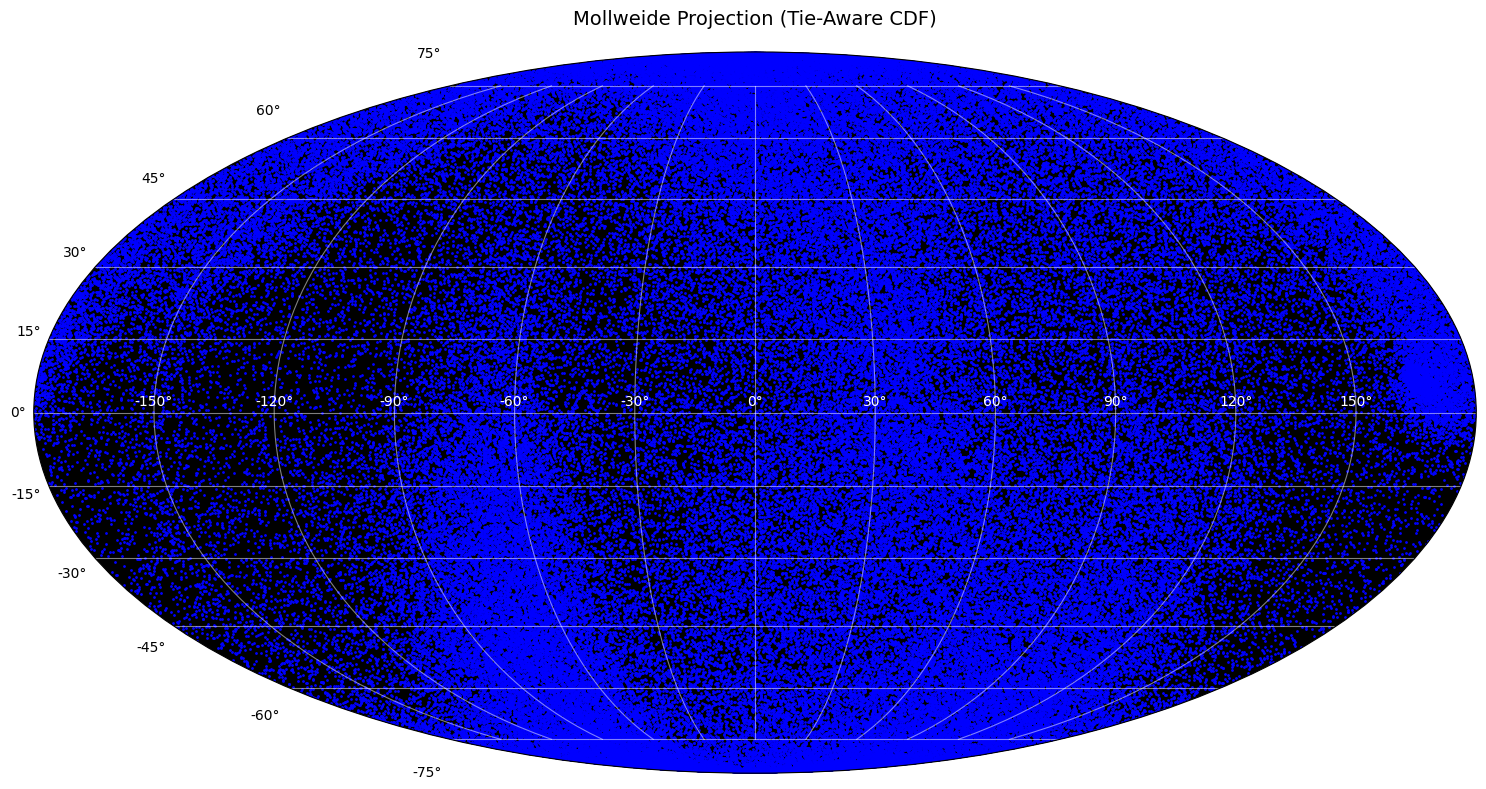

Mollweide projection complete.



In [56]:
print("Creating Mollweide projection...\n")

# Convert to radians for Mollweide
lon_plot_rad = np.deg2rad(lon_plot)
lat_plot_rad = np.deg2rad(lat_plot)

# Create figure
fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT), dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection='mollweide')
ax.set_facecolor('black')

# Plot points
if color_mode == 'uniform':
    ax.scatter(lon_plot_rad, lat_plot_rad,
               s=POINT_SIZE, alpha=POINT_ALPHA, c=COLOR, rasterized=True)
elif color_mode == 'scalar':
    scatter = ax.scatter(lon_plot_rad, lat_plot_rad,
                        s=POINT_SIZE, alpha=POINT_ALPHA, c=colors_plot,
                        cmap=COLORMAP, rasterized=True)
    plt.colorbar(scatter, ax=ax)
elif color_mode == 'subset':
    # Plot each subset separately for legend
    unique_subsets = torch.unique(subset_ids[plot_mask])
    for subset_id in unique_subsets:
        subset_idx = subset_ids[plot_mask] == subset_id
        subset_color = SUBSET_COLORS[int(subset_id) % len(SUBSET_COLORS)]
        ax.scatter(lon_plot_rad[subset_idx.cpu().numpy()],
                  lat_plot_rad[subset_idx.cpu().numpy()],
                  s=POINT_SIZE, alpha=POINT_ALPHA, c=subset_color,
                  label=f'Subset {int(subset_id)}', rasterized=True)
    ax.legend(loc='upper right', framealpha=0.9)

# Formatting
ax.grid(True, alpha=0.5, color='white')

# Set tick label colors independently
# In Mollweide: longitude labels are on equator (need white), latitude labels on sides (need black)
for label in ax.get_xticklabels():
    label.set_color('white')  # Longitude (equator) - white for visibility on black
for label in ax.get_yticklabels():
    label.set_color('black')  # Latitude (sides) - black for visibility on white paper

# Set tick mark colors independently
ax.tick_params(axis='x', which='both', length=0, colors='white')  # Longitude ticks
ax.tick_params(axis='y', which='both', length=0, colors='black')  # Latitude ticks

ax.set_title(f'Mollweide Projection{cdf_note}{mask_note}',
             color='black', pad=20, fontsize=14)

plt.tight_layout()
plt.show()

print("Mollweide projection complete.")
print()

### Rectangular Projection (Equirectangular)

Creating rectangular projection...



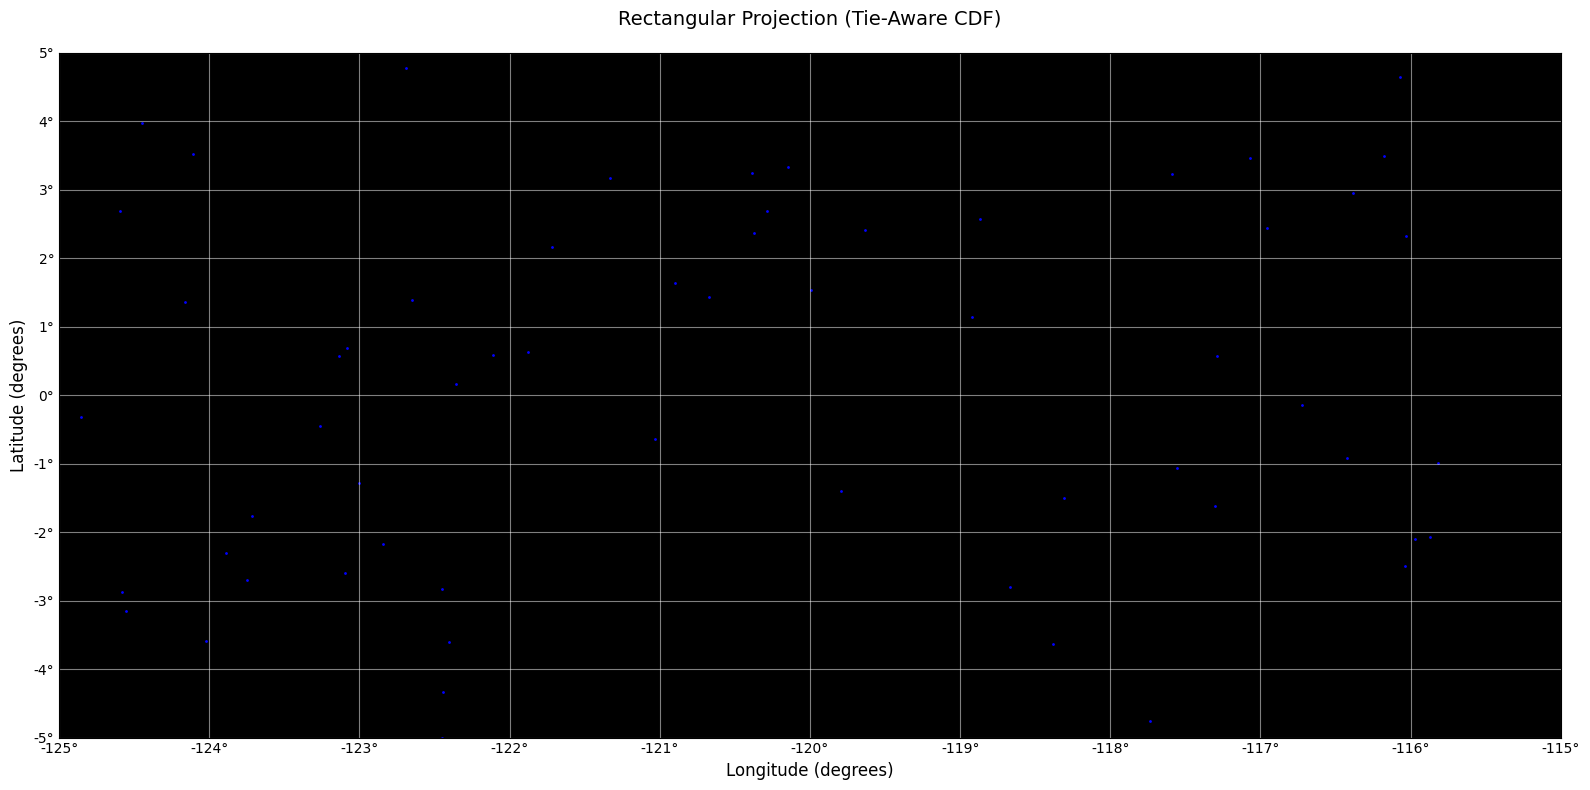

Rectangular projection complete.



In [57]:
print("Creating rectangular projection...\n")

# Create figure
fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT), dpi=FIGURE_DPI)
ax.set_facecolor('black')

# Plot points
if color_mode == 'uniform':
    ax.scatter(lon_plot, lat_plot,
               s=POINT_SIZE, alpha=POINT_ALPHA, c=COLOR, rasterized=True)
elif color_mode == 'scalar':
    scatter = ax.scatter(lon_plot, lat_plot,
                        s=POINT_SIZE, alpha=POINT_ALPHA, c=colors_plot,
                        cmap=COLORMAP, rasterized=True)
    plt.colorbar(scatter, ax=ax)
elif color_mode == 'subset':
    # Plot each subset separately for legend
    unique_subsets = torch.unique(subset_ids[plot_mask])
    for subset_id in unique_subsets:
        subset_idx = subset_ids[plot_mask] == subset_id
        subset_color = SUBSET_COLORS[int(subset_id) % len(SUBSET_COLORS)]
        ax.scatter(lon_plot[subset_idx.cpu().numpy()],
                  lat_plot[subset_idx.cpu().numpy()],
                  s=POINT_SIZE, alpha=POINT_ALPHA, c=subset_color,
                  label=f'Subset {int(subset_id)}', rasterized=True)
    ax.legend(loc='upper right', framealpha=0.9)

# Generate ticks
lon_ticks = np.arange(
    np.ceil(lon_min / lon_tick_spacing) * lon_tick_spacing,
    lon_max + lon_tick_spacing,
    lon_tick_spacing
)
lat_ticks = np.arange(
    np.ceil(lat_min / lat_tick_spacing) * lat_tick_spacing,
    lat_max + lat_tick_spacing,
    lat_tick_spacing
)

ax.set_xticks(lon_ticks)
ax.set_yticks(lat_ticks)
ax.set_xticklabels([f'{int(lon)}°' for lon in lon_ticks], color='black')
ax.set_yticklabels([f'{int(lat)}°' for lat in lat_ticks], color='black')

# Set tick colors independently
ax.tick_params(axis='x', which='both', length=0, colors='black')
ax.tick_params(axis='y', which='both', length=0, colors='black')

# Set limits
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

# Formatting
ax.grid(True, alpha=0.5, color='white', which='major')
ax.set_xlabel('Longitude (degrees)', color='black', fontsize=12)
ax.set_ylabel('Latitude (degrees)', color='black', fontsize=12)
ax.set_title(f'Rectangular Projection{cdf_note}{mask_note}',
             color='black', pad=20, fontsize=14)

# Set spine colors independently
ax.spines['top'].set_edgecolor('black')
ax.spines['bottom'].set_edgecolor('black')
ax.spines['left'].set_edgecolor('black')
ax.spines['right'].set_edgecolor('black')

plt.tight_layout()
plt.show()

print("Rectangular projection complete.")
print()

## Summary

In [58]:
print("=" * 60)
print("SKY MAP SUMMARY")
print("=" * 60)
print()
print(f"Input: {VECTORS_FILE}")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print()
print(f"Basis: {BASIS_FILE}")
print(f"  North (+Z): {BASIS_KEYS['north']}")
print(f"  Meridian (+X): {BASIS_KEYS['meridian']}")
print(f"  Equinox (+Y): {BASIS_KEYS['equinox']}")
print()
if viewpoint is not None:
    print(f"Viewpoint: {VIEWPOINT_FILE}")
else:
    print("Viewpoint: origin")
print()
print(f"View window:")
print(f"  Center: ({LOOKAT_LON:.1f}°, {LOOKAT_LAT:.1f}°)")
print(f"  FOV: {FOV_DIAMETER:.1f}°")
print(f"  Range: lon [{lon_min:.1f}°, {lon_max:.1f}°], lat [{lat_min:.1f}°, {lat_max:.1f}°]")
print()
print(f"CDF transform: {'enabled (tie-aware)' if USE_TIE_AWARE_CDF else 'disabled'}")
print()
print(f"Color mode: {color_mode}")
if color_mode == 'subset':
    print(f"  Subsets: {len(torch.unique(subset_ids))}")
elif color_mode == 'scalar':
    print(f"  Colormap: {COLORMAP}")
elif color_mode == 'uniform':
    print(f"  Color: {COLOR}")
print()
print(f"Points plotted: {n_plotted:,} (of {N:,} total)")
if n_masked > 0:
    print(f"Points masked: {n_masked:,}")
print()
print("Generated projections:")
print("  • Mollweide (equal-area)")
print("  • Rectangular (equirectangular)")
print()
print("=" * 60)

SKY MAP SUMMARY

Input: gamma_centered_qwen3_4b_instruct_2507.safetensors
  Tokens: 151,936
  Dimensions: 2,560

Basis: pca_basis_vectors.safetensors
  North (+Z): 1
  Meridian (+X): 2
  Equinox (+Y): 3

Viewpoint: origin

View window:
  Center: (-120.0°, 0.0°)
  FOV: 10.0°
  Range: lon [-125.0°, -115.0°], lat [-5.0°, 5.0°]

CDF transform: enabled (tie-aware)

Color mode: uniform
  Color: blue

Points plotted: 151,936 (of 151,936 total)

Generated projections:
  • Mollweide (equal-area)
  • Rectangular (equirectangular)

